In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy.stats import norm
from scipy.interpolate import make_interp_spline, BSpline

In [2]:
# approximate ln(z') = 0.7*ln(z) + ε' 
# sigma(ε) = 0.15
# Return values:
#    z_vals: array of possible ln(z) valus
#    trans_matrix: markov transition matrix
# by Tauchen and Hussey 
# Sources of help: 
#    http://www.chrisedmond.net/phd2014/90065_lecture3.pdf (page16,17)
#    https://python4econ.blogspot.com/2012/11/tauchen-hussey-numerical-integration.html

def approximateZValues(num_z, sigma, rho):
    sigma = sigma
    trans_matrix = np.zeros((num_z,num_z))
    
    # gauss hermite nodes and weights
    nodes, weights = np.polynomial.hermite.hermgauss(num_z)
    Zprob = np.zeros((num_z,num_z))
    
    nodes1 = nodes * np.sqrt(2 * (sigma**2))
    weights1 = weights / np.sqrt(np.pi)
    
    # iterate each z
    for i in range(num_z):
        
        # iterate next period z'
        for j in range(num_z):
            
            #p(xj|xi) = ɸ((xj - ((1-ro)M - r*xi))/σ)= ɸ((xj -(r*xi))/σ)
                                        #p(xj|xi)*wj/w(xj)
            trans_matrix[i,j] = norm.pdf(nodes1[j], rho*nodes1[i], sigma) * weights1[j]/ norm.pdf(nodes1[j], 0, sigma)

    sum_j = np.sum(trans_matrix, axis = 1)
    trans_matrix /= sum_j
    return nodes1, trans_matrix



In [3]:
# k - k index; z - z index
# helper function to find the max V'
def findMax(k,z):
    # for each k' and z calculate its expected V
    expected_V = np.dot(trans_matrix[z],value_function)
    expected_V = expected_V.reshape(num_k,1)
    
    #pi(k,z) - k' + (1- delta)*k
    V_tild = z_vals[z]*k_vals[k] ** theta + 1/(1+r)*expected_V - k_vals + (1-delta) * k_vals[k]
    
    # find the max V(k,k',z) of all
    max_V = np.max(V_tild)
    return max_V

In [4]:
# k - k index; z - z index
# helper function to find the policy make the max V'
def findArgMax(k,z):
    
    # for each k' and z calculate its expected V
    expected_V = np.dot(trans_matrix[z],value_function)
    expected_V = expected_V.reshape(num_k,1)
    
    #pi(k,z) - k' + (1- delta)*k
    V_tild = z_vals[z]*k_vals[k] ** theta + 1/(1+r)*expected_V - k_vals + (1-delta) * k_vals[k]
    max_V = np.argmax(V_tild)
    return max_V

In [5]:
# value iteration function (according to the pseudo code in RL book and algorithm described in Strebulaev Whited paper)
def valueIteration():
    delta = 1
    
    # keep iterating when not converge
    while(delta > theta):
        delta = 0
        
        # iterate each pair of (z,k)
        for z in range(num_z):
            for k in range(num_k):
                v = value_function[z][k]
                value_function[z][k] = findMax(k,z)
                delta = max(delta, np.abs(v - value_function[z][k]))
    
    # policy function h(k,z) = k'
    H = np.zeros((num_z, num_k))
    
    # find deterministic policy
    for z in range(num_z):
        for k in range(num_k):
            H[z][k] = int(findArgMax(k,z))
    return H

In [6]:
# all the parameters
num_z = 20
num_k = 30
rho = 0.7
theta = 0.7
sigma_epsilon = 0.15
delta = 0.15
r = 0.04
time = num_z

In [7]:
ln_z_vals, trans_matrix = approximateZValues(num_z, sigma_epsilon, rho)

# calculate possible z_vals z = e^ln(z)
z_vals = np.exp(ln_z_vals)
print("possible ln(z) values are: \n" + str(ln_z_vals))
print("\npossible z values are: \n" + str(z_vals))

possible ln(z) values are: 
[-1.14285728 -0.97658852 -0.83681082 -0.7101872  -0.5915951  -0.47835222
 -0.36879954 -0.2617871  -0.1564418  -0.05204462  0.05204462  0.1564418
  0.2617871   0.36879954  0.47835222  0.5915951   0.7101872   0.83681082
  0.97658852  1.14285728]

possible z values are: 
[0.31890651 0.37659365 0.43308952 0.49155217 0.55344378 0.61980385
 0.69156403 0.76967487 0.85518129 0.94928651 1.05342275 1.16934271
 1.2992499  1.44599771 1.61341366 1.80686826 2.03437206 2.30899143
 2.655382   3.1357152 ]


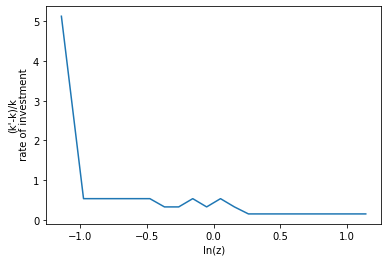

In [8]:
#initialize k to be a multiplicative sequence
k_vals = np.zeros((num_k,1))
k_vals[0] = 1

# # suppress scientific notation
# np.set_printoptions(suppress=True)
for i in range(1,num_k):
    k_vals[i] = k_vals[i - 1]/(1- delta)
    
value_function = np.zeros((num_z, num_k))

# no adjustment cost 
H = valueIteration()
k_index = int(0)

# vertical value (k' - k)/k
rate_invest = np.zeros(num_z)


# z_series = np.zeros((time, 1))
# z_series_val = np.zeros((time, 1))
# z_index = 0


# i = 0
# for i in range(time):
#     print(i)
#     z_series[i] = z_index
#     z_series_val[i] = z_vals[z_index]
#     rand_prob =np.random.uniform(0,1)
#     tmp_z = trans_matrix[z_index]
    
#     # keep track current z state < rand_prob
#     tmp_index = 0
#     sum_prob = 0
    
#     while(tmp_index < num_z):
#         if(rand_prob <= sum_prob):
#             break
#         sum_prob += tmp_z[tmp_index]
#         tmp_index += 1
#     z_index = tmp_index

# print("z series" + str(z_series))
# ln_z_series = np.log(z_series_val)


for j in range(num_z):
    #print("z"+str())
#     print(H[i][k_index])
#     tmp_index = int(z_series[j])
    k_prime_index = int(H[j][k_index])
    rate_invest[j] = (k_vals[k_prime_index] - (1-delta)*k_vals[k_index])/k_vals[k_index]
    k_index = k_prime_index

plt.plot(ln_z_vals, rate_invest)
plt.xlabel("ln(z)")
plt.ylabel("(k'-k)/k\n rate of investment")
plt.show()

In [9]:
print("H policy is \n" + str(H))
print("rate" + str(rate_invest))

H policy is 
[[11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11.
  11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11.]
 [13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13.
  13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13.]
 [15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15.
  15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15.]
 [17. 17. 17. 17. 17. 17. 17. 17. 17. 17. 17. 17. 17. 17. 17. 17. 17. 17.
  17. 17. 17. 17. 17. 17. 17. 17. 17. 17. 17. 17.]
 [19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19.
  19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19.]
 [21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21.
  21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21.]
 [22. 22. 22. 22. 22. 22. 22. 22. 22. 22. 22. 22. 22. 22. 22. 22. 22. 22.
  22. 22. 22. 22. 22. 22. 22. 22. 22. 22. 22. 22.]
 [23. 23. 23. 23. 23. 23. 23. 23. 23. 23. 23. 23. 23. 23. 23. 23. 23. 23.
  23. 23. 23. 23. 23. 23. 23. 23. 23. 